In [1]:
# Import necessary libraries and define the data loading function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import requests

# Set Random Seed and Device Configuration
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if CUDA (GPU) is available and select the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(torch.version.cuda)
torch.cuda.empty_cache()

print("torch.cuda.device_count():", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Using device: cuda
12.4
torch.cuda.device_count(): 4
Device 0: NVIDIA RTX A5500
Device 1: NVIDIA RTX A5500
Device 2: NVIDIA RTX A5500
Device 3: NVIDIA RTX A5500


In [2]:
# Data load
def load_shakespeare_data(sequence_length=20, batch_size=128):
    """
    Downloads the tiny Shakespeare dataset, encodes it at character-level,
    and creates DataLoaders for training (80%) and validation (20%).
    
    :param sequence_length: The length of the character sequence for each sample
    :param batch_size: The batch size used in the DataLoaders
    :return: train_loader, test_loader, vocab_size, int_to_char
    """
    # Step 1: Download the dataset
    # Download the dataset
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    text = response.text  # entire text data
    
    # Step 2: Prepare the dataset
    # Create a character-integer mapping
    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    vocab_size = len(chars)
    
    # Encode text
    encoded_text = [char_to_int[ch] for ch in text]
    
    # Create sequences and targets
    sequences = []
    targets = []
    for i in range(0, len(encoded_text) - sequence_length):
        seq = encoded_text[i : i + sequence_length]
        target = encoded_text[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    
    # Convert lists to PyTorch tensors
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    
    # Step 3: Create a dataset class
    class CharDataset(Dataset):
        def __init__(self, seqs, targs):
            self.seqs = seqs
            self.targs = targs
        def __len__(self):
            return len(self.seqs)
        def __getitem__(self, idx):
            return self.seqs[idx], self.targs[idx]
    
    # Instantiate the dataset
    dataset = CharDataset(sequences, targets)
    
    # Step 4: Create data loaders
    # Split train/test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
    
    return train_loader, test_loader, vocab_size, int_to_char

In [3]:
# Model definitions (LSTM & GRU) with adjustable HYPERPARAMETERS
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=1):
        """
        LSTM-based model for character-level prediction
        :param vocab_size: number of unique characters
        :param embed_size: dimension of the embedding layer
        :param hidden_size: dimension of the hidden state
        :param num_layers: number of LSTM layers
        """
        super(ShakespeareLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        # x shape: (batch, seq_length)
        embedded = self.embedding(x)
        # output shape: (batch, seq_length, hidden_size)
        output, _ = self.lstm(embedded)
        # Take only the last time-step output
        last_output = output[:, -1, :]  # shape: (batch, hidden_size)
        logits = self.fc(last_output)   # shape: (batch, vocab_size)
        return logits

class ShakespeareGRU(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=1):
        """
        GRU-based model for character-level prediction
        :param vocab_size: number of unique characters
        :param embed_size: dimension of the embedding layer
        :param hidden_size: dimension of the hidden state
        :param num_layers: number of GRU layers
        """
        super(ShakespeareGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        last_output = output[:, -1, :]
        logits = self.fc(last_output)
        return logits

In [4]:
# Utility functions (param count, train eval)
def count_parameters(model):
    """
    Returns the total number of trainable parameters of a model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_one_epoch(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    running_loss = 0.0
    total_samples = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_x.size(0)
        total_samples += batch_x.size(0)
    
    epoch_loss = running_loss / total_samples
    return epoch_loss

def evaluate(model, loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    correct = 0
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)
            
            # Accuracy: compare argmax of outputs with labels
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
    
    epoch_loss = running_loss / total_samples
    accuracy = correct / total_samples
    return epoch_loss, accuracy

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    """
    Train the given model for a specified number of epochs,
    returning lists of train losses, val losses, and val accuracies.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    elapsed = time.time() - start_time
    print(f"Training completed in {elapsed:.2f} seconds")
    return train_losses, val_losses, val_accuracies, elapsed

In [5]:
# Experiments
# 1) Run LSTM & GRU for seq_length=20 and seq_length=30, then compare.
# 2) Adjust hyperparameters (e.g., hidden_size, num_layers) to see the effects.
# 3) Increase sequence length to 50 and observe the results.

def run_experiment(sequence_length, model_type='LSTM', embed_size=128, hidden_size=128, 
                   num_layers=1, epochs=10, lr=0.001, batch_size=128, device='cpu'):
    """
    Runs a single experiment on the tiny Shakespeare dataset with the specified configuration.
    Returns the training logs and performance metrics.
    """
    # Load data
    train_loader, test_loader, vocab_size, int_to_char = load_shakespeare_data(
        sequence_length=sequence_length, 
        batch_size=batch_size
    )
    
    # Initialize model
    if model_type == 'LSTM':
        model = ShakespeareLSTM(vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)
    elif model_type == 'GRU':
        model = ShakespeareGRU(vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)
    else:
        raise ValueError("model_type must be either 'LSTM' or 'GRU'")
    
    # Wrap the model with DataParallel if multiple GPUs are available
    # if torch.cuda.device_count() > 1:
    #     print(f"Using {torch.cuda.device_count()} GPUs for training")
    #     model = nn.DataParallel(model)
    
    # Count parameters
    param_count = count_parameters(model)
    print(f"\nRunning {model_type} with seq_length={sequence_length}, hidden_size={hidden_size}, "
          f"layers={num_layers}, param_count={param_count}")
    
    # Train
    train_losses, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, test_loader, epochs=epochs, lr=lr, device=device
    )
    
    return {
        'model_type': model_type,
        'sequence_length': sequence_length,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'param_count': param_count,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'training_time': training_time
    }

In [6]:
# Running baseline experiments for seq_length=20 and seq_length=30 with default hyperparams
epochs = 20
lr = 0.001
hidden_size = 128
batch_size = 128

results = []

# LSTM, seq_length=20
res_lstm_SL20 = run_experiment(sequence_length=20, model_type='LSTM', 
                             hidden_size=hidden_size, num_layers=1, 
                             epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_lstm_SL20)

# GRU, seq_length=20
res_gru_SL20 = run_experiment(sequence_length=20, model_type='GRU', 
                            hidden_size=128, num_layers=1, 
                            epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_gru_SL20)

# LSTM, seq_length=30
res_lstm_SL30 = run_experiment(sequence_length=30, model_type='LSTM', 
                             hidden_size=128, num_layers=1, 
                             epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_lstm_SL30)

# GRU, seq_length=30
res_gru_SL30 = run_experiment(sequence_length=30, model_type='GRU', 
                            hidden_size=128, num_layers=1, 
                            epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_gru_SL30)


Running LSTM with seq_length=20, hidden_size=128, layers=1, param_count=148801
Epoch 1/20, Train Loss: 1.8342, Val Loss: 1.6405, Val Acc: 0.5107
Epoch 2/20, Train Loss: 1.5808, Val Loss: 1.5528, Val Acc: 0.5316
Epoch 3/20, Train Loss: 1.5131, Val Loss: 1.5088, Val Acc: 0.5446
Epoch 4/20, Train Loss: 1.4756, Val Loss: 1.4906, Val Acc: 0.5481
Epoch 5/20, Train Loss: 1.4511, Val Loss: 1.4710, Val Acc: 0.5528
Epoch 6/20, Train Loss: 1.4319, Val Loss: 1.4544, Val Acc: 0.5573
Epoch 7/20, Train Loss: 1.4174, Val Loss: 1.4450, Val Acc: 0.5595
Epoch 8/20, Train Loss: 1.4056, Val Loss: 1.4389, Val Acc: 0.5621
Epoch 9/20, Train Loss: 1.3959, Val Loss: 1.4329, Val Acc: 0.5637
Epoch 10/20, Train Loss: 1.3878, Val Loss: 1.4304, Val Acc: 0.5625
Epoch 11/20, Train Loss: 1.3810, Val Loss: 1.4245, Val Acc: 0.5637
Epoch 12/20, Train Loss: 1.3749, Val Loss: 1.4195, Val Acc: 0.5660
Epoch 13/20, Train Loss: 1.3694, Val Loss: 1.4200, Val Acc: 0.5654
Epoch 14/20, Train Loss: 1.3648, Val Loss: 1.4144, Val Acc

Hyperparameter adjustment

In [ ]:
# Changing the number of hidden size

# 256 hidden size LSTM, seq_length=20, hidden_size=256
res_lstm_HS256 = run_experiment(sequence_length=20, model_type='LSTM', 
                                  hidden_size=256, num_layers=1, 
                                  epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_lstm_HS256)

# 2-layer GRU, seq_length=20, hidden_size=128
res_gru_HS256 = run_experiment(sequence_length=20, model_type='GRU', 
                                 hidden_size=256, num_layers=1, 
                                 epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_gru_HS256)


Running LSTM with seq_length=20, hidden_size=256, layers=1, param_count=420289
Epoch 1/20, Train Loss: 1.7057, Val Loss: 1.5183, Val Acc: 0.5390
Epoch 2/20, Train Loss: 1.4610, Val Loss: 1.4466, Val Acc: 0.5578
Epoch 3/20, Train Loss: 1.3983, Val Loss: 1.4056, Val Acc: 0.5693
Epoch 4/20, Train Loss: 1.3621, Val Loss: 1.3918, Val Acc: 0.5719
Epoch 5/20, Train Loss: 1.3375, Val Loss: 1.3820, Val Acc: 0.5743
Epoch 6/20, Train Loss: 1.3191, Val Loss: 1.3701, Val Acc: 0.5790
Epoch 7/20, Train Loss: 1.3037, Val Loss: 1.3673, Val Acc: 0.5783
Epoch 8/20, Train Loss: 1.2916, Val Loss: 1.3639, Val Acc: 0.5806
Epoch 9/20, Train Loss: 1.2806, Val Loss: 1.3650, Val Acc: 0.5799
Epoch 10/20, Train Loss: 1.2718, Val Loss: 1.3579, Val Acc: 0.5835
Epoch 11/20, Train Loss: 1.2641, Val Loss: 1.3599, Val Acc: 0.5829
Epoch 12/20, Train Loss: 1.2577, Val Loss: 1.3595, Val Acc: 0.5823
Epoch 13/20, Train Loss: 1.2517, Val Loss: 1.3631, Val Acc: 0.5798
Epoch 14/20, Train Loss: 1.2463, Val Loss: 1.3628, Val Acc

In [7]:
# Changing the number of layers

# 2-layer LSTM, seq_length=20, hidden_size=128
res_lstm_2layers = run_experiment(sequence_length=20, model_type='LSTM', 
                                  hidden_size=128, num_layers=2, 
                                  epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_lstm_2layers)

# 2-layer GRU, seq_length=20, hidden_size=128
res_gru_2layers = run_experiment(sequence_length=20, model_type='GRU', 
                                 hidden_size=128, num_layers=2, 
                                 epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_gru_2layers)


Running LSTM with seq_length=20, hidden_size=128, layers=2, param_count=280897
Epoch 1/20, Train Loss: 1.8117, Val Loss: 1.5884, Val Acc: 0.5223
Epoch 2/20, Train Loss: 1.5259, Val Loss: 1.4929, Val Acc: 0.5481
Epoch 3/20, Train Loss: 1.4525, Val Loss: 1.4468, Val Acc: 0.5577
Epoch 4/20, Train Loss: 1.4112, Val Loss: 1.4219, Val Acc: 0.5642
Epoch 5/20, Train Loss: 1.3833, Val Loss: 1.4040, Val Acc: 0.5690
Epoch 6/20, Train Loss: 1.3624, Val Loss: 1.3940, Val Acc: 0.5711
Epoch 7/20, Train Loss: 1.3454, Val Loss: 1.3862, Val Acc: 0.5746
Epoch 8/20, Train Loss: 1.3318, Val Loss: 1.3767, Val Acc: 0.5765
Epoch 9/20, Train Loss: 1.3199, Val Loss: 1.3720, Val Acc: 0.5783
Epoch 10/20, Train Loss: 1.3100, Val Loss: 1.3699, Val Acc: 0.5788
Epoch 11/20, Train Loss: 1.3010, Val Loss: 1.3666, Val Acc: 0.5791
Epoch 12/20, Train Loss: 1.2934, Val Loss: 1.3624, Val Acc: 0.5804
Epoch 13/20, Train Loss: 1.2859, Val Loss: 1.3630, Val Acc: 0.5808
Epoch 14/20, Train Loss: 1.2791, Val Loss: 1.3624, Val Acc

In [9]:
# Increase sequence length to 50
res_lstm_SL50 = run_experiment(sequence_length=50, model_type='LSTM', 
                             hidden_size=128, num_layers=1, 
                             epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_lstm_SL50)

res_gru_SL50 = run_experiment(sequence_length=50, model_type='GRU', 
                            hidden_size=128, num_layers=1, 
                            epochs=epochs, lr=lr, batch_size=128, device=device)
results.append(res_gru_SL50)


Running LSTM with seq_length=50, hidden_size=128, layers=1, param_count=148801
Epoch 1/20, Train Loss: 1.8348, Val Loss: 1.6264, Val Acc: 0.5139
Epoch 2/20, Train Loss: 1.5762, Val Loss: 1.5367, Val Acc: 0.5377
Epoch 3/20, Train Loss: 1.5096, Val Loss: 1.4963, Val Acc: 0.5462
Epoch 4/20, Train Loss: 1.4711, Val Loss: 1.4697, Val Acc: 0.5551
Epoch 5/20, Train Loss: 1.4454, Val Loss: 1.4534, Val Acc: 0.5596
Epoch 6/20, Train Loss: 1.4261, Val Loss: 1.4399, Val Acc: 0.5630
Epoch 7/20, Train Loss: 1.4113, Val Loss: 1.4310, Val Acc: 0.5639
Epoch 8/20, Train Loss: 1.3991, Val Loss: 1.4208, Val Acc: 0.5673
Epoch 9/20, Train Loss: 1.3890, Val Loss: 1.4175, Val Acc: 0.5671
Epoch 10/20, Train Loss: 1.3802, Val Loss: 1.4091, Val Acc: 0.5703
Epoch 11/20, Train Loss: 1.3727, Val Loss: 1.4027, Val Acc: 0.5725
Epoch 12/20, Train Loss: 1.3664, Val Loss: 1.4031, Val Acc: 0.5724
Epoch 13/20, Train Loss: 1.3607, Val Loss: 1.3976, Val Acc: 0.5752
Epoch 14/20, Train Loss: 1.3557, Val Loss: 1.3970, Val Acc

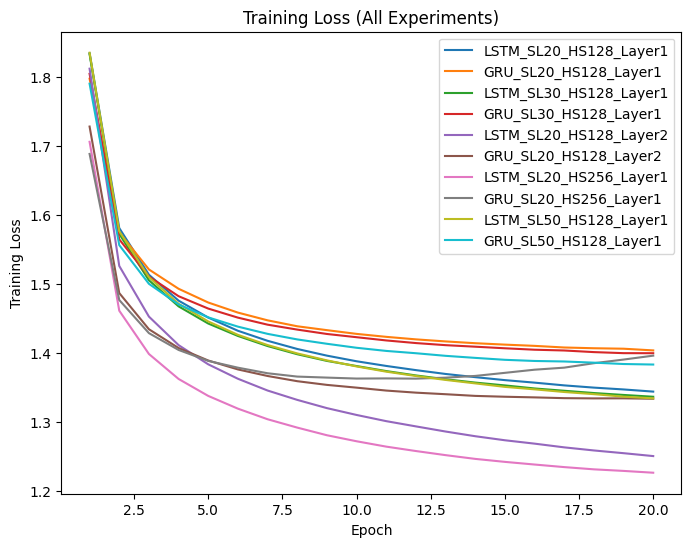

In [17]:
# Plot training loss curves
def plot_training_losses(results_list, key='train_losses', title='Training Loss', filename='p2_train_loss'):
    """
    Plots the training loss over epochs for each result in results_list.
    """
    plt.figure(figsize=(8,6))
    for r in results_list:
        epochs_range = range(1, len(r[key]) + 1)
        label = f"{r['model_type']}_SL{r['sequence_length']}_HS{r['hidden_size']}_Layer{r['num_layers']}"
        plt.plot(epochs_range, r[key], label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.savefig(f"images/{filename}.png")
    plt.show()

# Plot training losses for all experiments
plot_training_losses(results, key='train_losses', title='Training Loss (All Experiments)', filename='p2_train_loss')

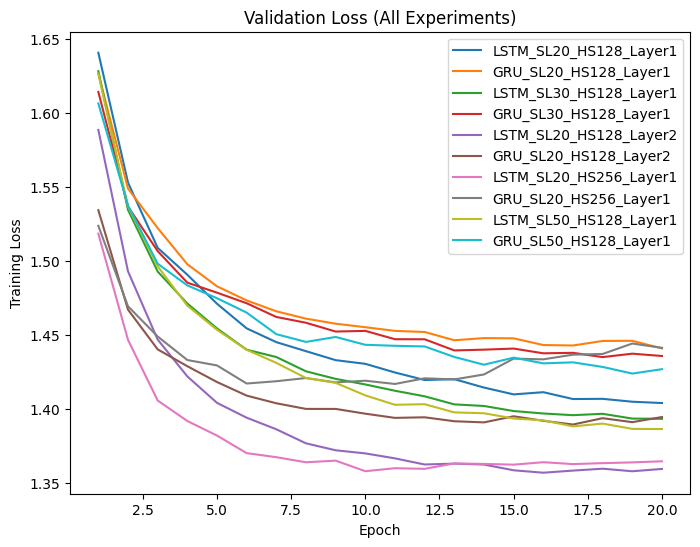

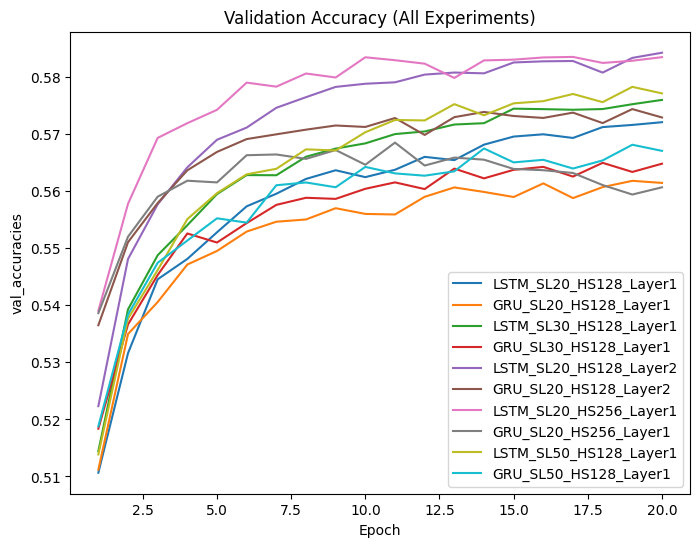

In [18]:
# Plot validation curves curves
import math

def plot_learning_curves(results_list, key='val_accuracies', title='Validation Accuracy', filename='p2_vali_accuracy'):
    """
    Plots the specified metric (e.g. val_accuracies) over epochs for each result in results_list.
    """
    plt.figure(figsize=(8,6))
    for r in results_list:
        epochs_range = range(1, len(r[key]) + 1)
        label = f"{r['model_type']}_SL{r['sequence_length']}_HS{r['hidden_size']}_Layer{r['num_layers']}"
        plt.plot(epochs_range, r[key], label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.savefig(f"images/{filename}.png")
    plt.show()

# Plot training losses for all experiments
plot_training_losses(results, key='val_losses', title='Validation Loss (All Experiments)', filename='p2_vali_loss')
# Example: Plot validation accuracy for all experiments
plot_learning_curves(results, key='val_accuracies', title='Validation Accuracy (All Experiments)', filename='p2_vali_accuracy')

In [28]:
print("\nSUMMARY OF EXPERIMENTS:")
print("Model | SeqLen | HiddenSize | Layers |    Params   | Final Train Loss | Final Val Loss | Final Val Acc | Training Time (s)")
for r in results:
    final_train_loss = r['train_losses'][-1]
    final_val_loss = r['val_losses'][-1]
    final_val_acc = r['val_accuracies'][-1]
    training_time = r['training_time']
    print(f"{r['model_type']:5s} | {r['sequence_length']:6d} | {r['hidden_size']:10d} | {r['num_layers']:6d} | "
          f"{r['param_count']:11d} | {final_train_loss:16.4f} | {final_val_loss:14.4f} | {final_val_acc:13.4f} | {training_time:16.2f}")



SUMMARY OF EXPERIMENTS:
Model | SeqLen | HiddenSize | Layers |    Params   | Final Train Loss | Final Val Loss | Final Val Acc | Training Time (s)
LSTM  |     20 |        128 |      1 |      148801 |           1.3438 |         1.4039 |        0.5721 |           169.94
GRU   |     20 |        128 |      1 |      115777 |           1.4035 |         1.4408 |        0.5614 |           162.34
LSTM  |     30 |        128 |      1 |      148801 |           1.3363 |         1.3933 |        0.5760 |           199.60
GRU   |     30 |        128 |      1 |      115777 |           1.3994 |         1.4357 |        0.5648 |           180.45
LSTM  |     20 |        128 |      2 |      280897 |           1.2504 |         1.3594 |        0.5843 |           232.57
GRU   |     20 |        128 |      2 |      214849 |           1.3334 |         1.3945 |        0.5729 |           183.21
LSTM  |     20 |        256 |      1 |      420289 |           1.2263 |         1.3646 |        0.5835 |           215.3